In [1]:
%matplotlib inline

In [2]:
import numpy as np
from copy import deepcopy
import math,random 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

### パーティクル

In [3]:
class Particle:
    def __init__(self, p, w):
        self.pose = np.array(p)
        self.weight = w
        
    def __repr__(self):
        return "pose: {}, weight] {}".format(self.pose, self.weight)

### ロボットの制御則

In [4]:
def f(x_old, u):
    pos_x, pos_y, pos_theta = x_old
    act_fw, act_rot = u
    
    act_fw = random.gauss(act_fw, act_fw/10.0)
    dir_error = random.gauss(0.0, math.radians(3.0))
    act_rot = random.gauss(act_rot, act_rot/10.0)
    
    pos_x += act_fw * math.cos(pos_theta + dir_error)
    pos_y += act_fw * math.sin(pos_theta + dir_error)
    pos_theta += act_rot
    
    return np.array([pos_x, pos_y, pos_theta])

### ランドマークの相対距離と相対角度

In [5]:
def relative_landmark_pos(pose, landmark):
    x, y, theta = pose
    lx, ly = landmark
    distance = math.sqrt((x-lx)**2 + (y-ly)**2)
    direction = math.atan2(ly-y, lx-x)-theta
    
    return (distance, direction, lx, ly)

### 観測

In [6]:
def observation(pose, landmark):
    actual_distance, actual_direction, lx, ly = relative_landmark_pos(pose, landmark)
    if(math.cos(actual_direction) < 0.0):
        return None
    
    measured_distance = random.gauss(actual_distance, actual_distance*0.1)
    measured_direction = random.gauss(actual_direction, math.radians(5.0))
    
    return (measured_distance, measured_direction, lx, ly)

def observations(pose, landmarks):
    return list(filter(lambda x: x != None, [observation(pose, e) for e in landmarks]))

### 尤度計算とパーティクルに尤度を反映

In [7]:
def likelihood(pose, measurement):
    x, y, theta = pose
    distance, direction, lx, ly = measurement
    
    rel_distance, rel_direction, tmp_x, tmp_y = relative_landmark_pos(pose, (lx, ly))
    
    return norm.pdf(x=distance-rel_distance, loc=0.0, scale=rel_distance/10.0)*norm.pdf(x=direction-rel_direction, loc=0.0, scale=math.radians(5.0))

def change_weights(particles, measurement):
    for p in particles:
        p.weight *= likelihood(p.pose, measurement)
        
    ws = [p.weight for p in particles]
    s = sum(ws)
    for p in particles:
        p.weight = p.weight/s

### リサンプリング

In [8]:
def resampling(particles):
    accum = []
    sm = 0.0
    for p in particles:
        accum.append(p.weight+sm)
        sm+=p.weight
    pointer = random.uniform(0.0, 1.0/len(particles))
    new_particles = []
    particles_num = len(particles)
    
    while pointer < 1.0:
        if accum[0] >= pointer:
            new_particles.append(Particle(deepcopy(particles[0].pose), 1.0/particles_num))
            pointer += 1.0/particles_num
        else:
            accum.pop(0)
            particles.pop(0)
            
    return new_particles

### 描画

In [9]:
def draw_landmarks(landmarks):
    xs = [e[0] for e in landmarks]
    ys = [e[1] for e in landmarks]
    plt.scatter(xs, ys, s=300, marker="*", label="landmarks", color="orange")

def draw_observation(pose, measurement):
    x, y, theta = pose
    distance, direction, lx, ly = measurement
    lx = distance * math.cos(theta + direction) + x
    ly = distance * math.sin(theta + direction) + y
    plt.plot([pose[0], lx], [pose[1], ly], color="pink")
    
def draw_observations(pose, measurements):
    for m in measurements:
        draw_observation(pose, m)
        
def draw_robot(pose, color="red", label="actual robot motion"):
    plt.quiver([pose[0]], [pose[1]], [math.cos(pose[2])], [math.sin(pose[2])], color=color, label=label)
    
def draw(pose, particles):
    fig = plt.figure(i, figsize=(8,8))
    sp = fig.add_subplot(111, aspect="equal")
    sp.set_xlim(-1.0, 1.0)
    sp.set_ylim(-0.5, 1.5)
    
    xs = [e.pose[0] for e in particles]
    ys = [e.pose[1] for e in particles]
    vxs = [math.cos(e.pose[2])*e.weight for e in particles]
    vys = [math.sin(e.pose[2])*e.weight for e in particles]
    plt.quiver(xs, ys, vxs, vys, color="b", label="particles")
    
    draw_robot(pose)

### ランドマーク

In [10]:
actual_landmarks = [
    np.array([-0.5, 0.0]),
    np.array([0.5, 0.0]),
    np.array([0.0, 0.5])
]

In [11]:
actual_x = np.zeros(3)
path = [actual_x]

u = np.array([0.2,math.pi / 180.0 * 20])

num_paricles = 100
particles = [Particle([0.0, 0.0, 0.0], 1.0/num_paricles) for i in range(num_paricles)]
particles_path = [deepcopy(particles)]

measurementss = [observations(actual_x, actual_landmarks)]

maxw_estimates = [np.zeros(3)]
meanw_estimates = [np.zeros(3)]

for i in range(10):
    actual_x = f(actual_x, u)
    path.append(actual_x)
    ms = observations(actual_x, actual_landmarks)
    measurementss.append(ms)
    
    for p in particles:
        p.pose = f(p.pose, u)
        
    for m in ms:
        change_weights(particles, m)
    
    maxw = np.argmax([p.weight for p in particles])
    maxw_estimates.append(particles[maxw].pose)
    
    weightlist = [p.weight for p in particles]
    sw = sum(weightlist)
    weightlist = [w/sw for w in weightlist]
    meanw_pose = np.zeros(3)
    for i in range(len(meanw_pose)):
        meanw_pose[i] = sum([p.pose[i]*w for p, w in zip(particles, weightlist)])
    
    meanw_estimates.append(meanw_pose)
    
    particles = resampling(particles)
    
    particles_path.append(deepcopy(particles))

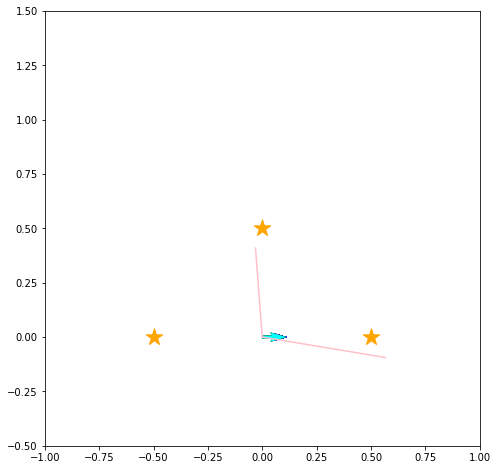

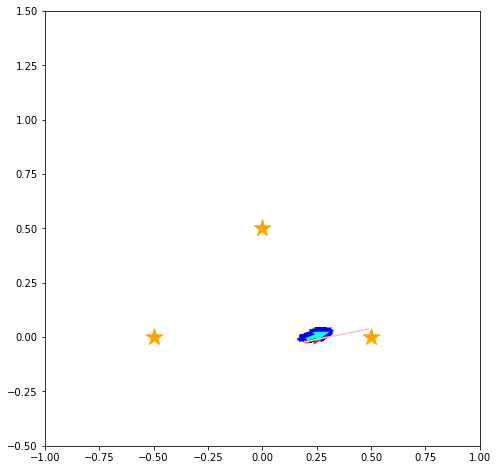

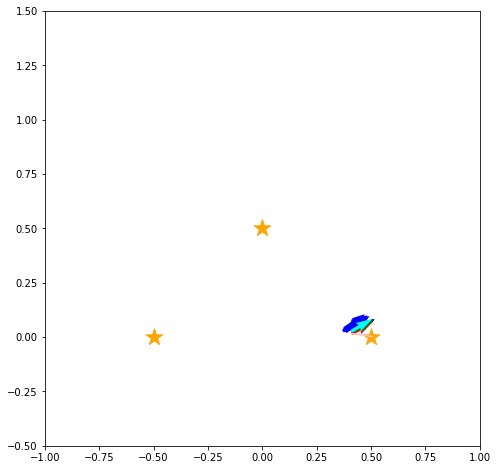

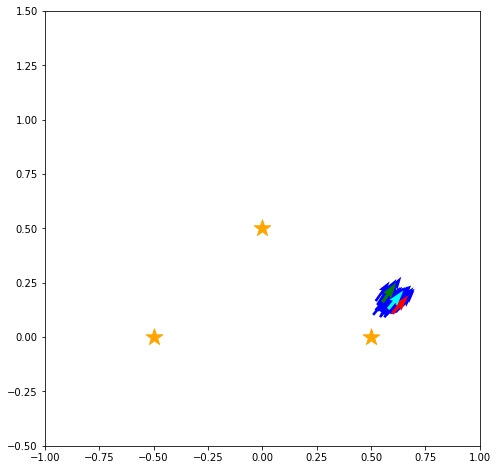

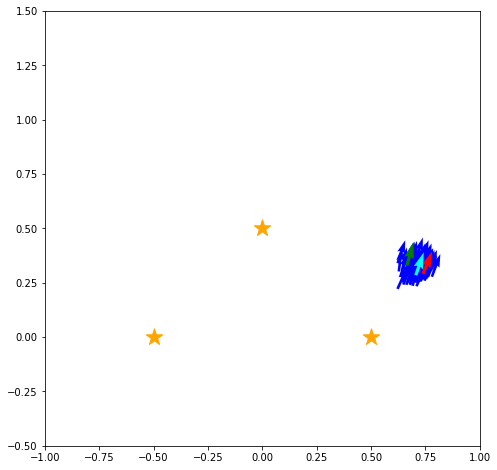

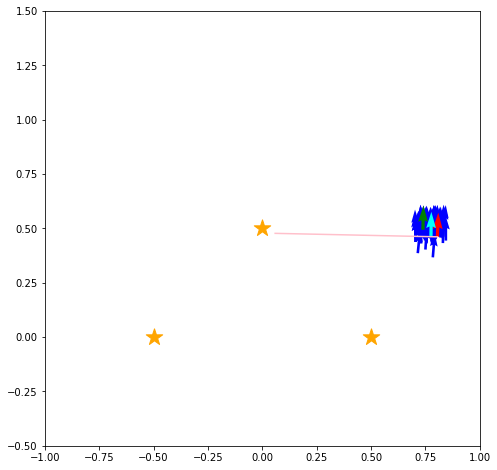

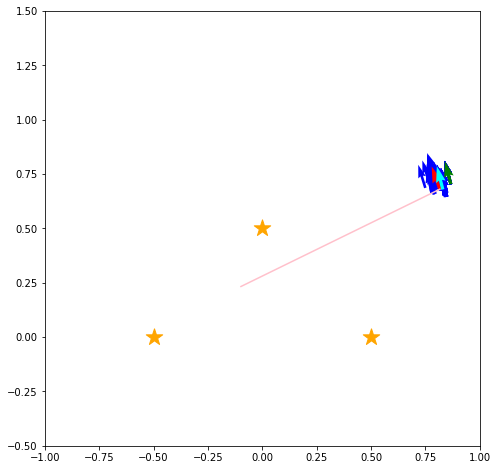

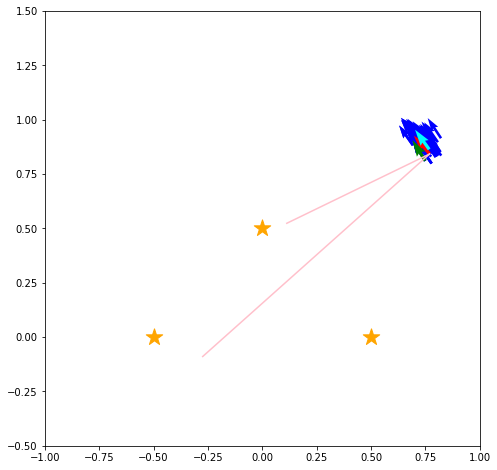

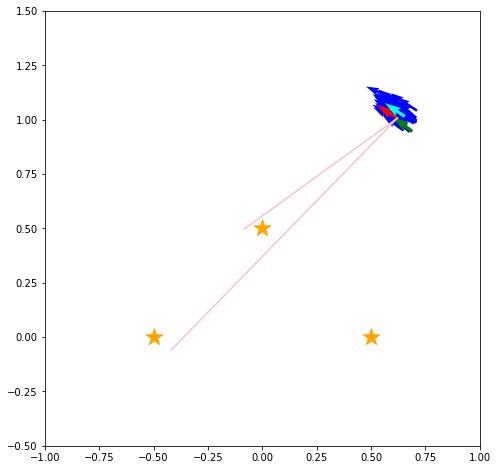

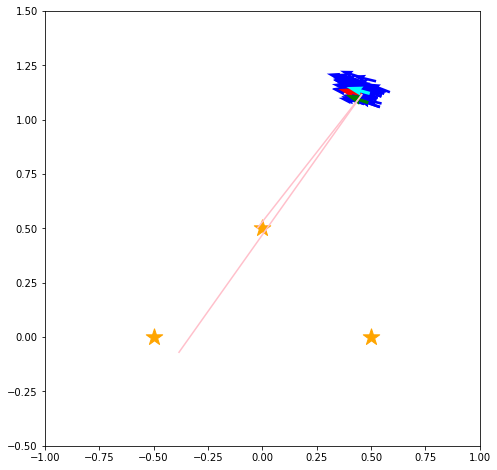

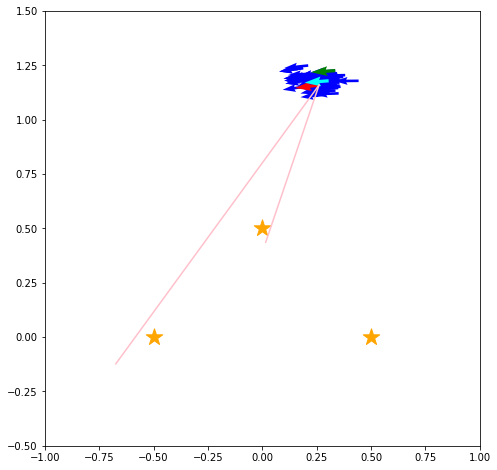

In [12]:
for i, p in enumerate(path):
    draw(path[i], particles_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i], measurementss[i])
    draw_robot(maxw_estimates[i], "green", "max weight estimate")
    draw_robot(meanw_estimates[i], "cyan", "mean weight estimate")